# Explore the relationship between hospitalization duration and diagnosis codes

In [1]:
import sys
sys.path.append("/home/wanxinli/deep_patient/")

from ast import literal_eval
from common import *
from mimic_common import *
from multiprocess import Pool
import os
import random
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import time


/home/wanxinli/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
output_dir = os.path.join(os.path.expanduser("~"), f"deep_patient/outputs/mimic")
print(f"Will save outputs to {output_dir}")

Will save outputs to /home/wanxinli/deep_patient/outputs/mimic


In [3]:
""" 
Read in the original dataframe
"""
admid_diagnosis_df = pd.read_csv("../../outputs/mimic/ADMID_DIAGNOSIS.csv", index_col=0, header=0, converters={'ICD codes': literal_eval})
print(admid_diagnosis_df)

""" 
Print number of patients for each category
"""
print("female:", admid_diagnosis_df.loc[(admid_diagnosis_df['gender'] == 'F')].shape[0])
print("male:", admid_diagnosis_df.loc[(admid_diagnosis_df['gender'] == 'M')].shape[0])


         adm_type gender                                          ICD codes  \
admid                                                                         
172335  EMERGENCY      F  [403.01, 486, 582.81, 585.5, 425.4, 276.2, 710...   
173633  EMERGENCY      F  [403.01, 585.6, 583.81, 710.0, 558.9, 287.5, 2...   
174105  EMERGENCY      M               [531.00, 410.71, 285.9, 414.01, 725]   
109976  EMERGENCY      M                             [191.5, 331.4, 530.81]   
178393   ELECTIVE      M       [414.01, 411.1, 482.83, 285.9, 272.0, 305.1]   
...           ...    ...                                                ...   
172304   ELECTIVE      F       [202.80, 348.5, 784.3, 401.9, 272.0, 530.81]   
152542  EMERGENCY      M  [566, 250.62, 357.2, V58.67, 427.31, 401.9, 42...   
161999  EMERGENCY      M  [434.11, 348.5, 348.4, 430, 348.30, 997.31, 51...   
189314  EMERGENCY      F  [346.80, 784.3, 745.5, 781.94, 368.40, 781.3, ...   
168949  EMERGENCY      M  [052.9, 416.2, 201.92, 135

In [4]:
"""
Train deep patient model and generate representations for targets and sources
"""

def custom_train_reps(target_features, source_features, n_components, pca_explain=False):
    """ 
    Customized training algorithm for generating target representations and source representations

    :param bool pca_explain: print the explained variance of each components
    
    :returns: target representations, source representations
    """
    source_pca = PCA(n_components=n_components)
    target_pca = PCA(n_components=n_components)
    target_reps = target_pca.fit_transform(target_features)
    source_reps = source_pca.fit_transform(source_features)

    if pca_explain:
        source_exp_var = source_pca.explained_variance_ratio_
        source_cum_sum_var = np.cumsum(source_exp_var)
        target_exp_var = target_pca.explained_variance_ratio_
        target_cum_sum_var = np.cumsum(target_exp_var)
        print("Cummulative variance explained by the source PCA is:", source_cum_sum_var[-1])
        print("Cummulative variance explained by the target PCA is:", target_cum_sum_var[-1])

    return target_reps, source_reps

In [5]:
n_components = 50
model_func = linear_model.LinearRegression
entire_proc_cts(n_components, admid_diagnosis_df, custom_train_reps, model_func, male_count = 120, female_count = 100, pca_explain=True)

Cummulative variance explained by the source PCA is: 0.8031792538773624
Cummulative variance explained by the target PCA is: 0.7675603152513721


(320180.28386849456,
 410193.4699735666,
 942276.4595524003,
 1341135.7592013786,
 699903.9719852144,
 1144542.0423471218)

Run one iteration using Linear regression

Study the admission map

In [6]:

""" 
Obtain the female count by male count coupling
"""

model_func = linear_model.LinearRegression
male_count = 120
female_count = 100
selected_df = select_df_cts(admid_diagnosis_df, male_count=male_count, female_count=female_count)
selected_df = selected_df.drop(columns=['adm_type', 'diagnosis', 'label'])
selected_df_male = selected_df[selected_df['gender']=='M']
selected_df_female = selected_df[selected_df['gender']=='F']
selected_df_male.to_csv(os.path.join(output_dir, "selected_df_male.csv"), header=True, index=True)
selected_df_female.to_csv(os.path.join(output_dir, "selected_df_female.csv"), header=True, index=True)

target_features, target_labels, source_features, source_labels = gen_features_duration(selected_df)

target_reps, source_reps = custom_train_reps(target_features, source_features, n_components)
np.savetxt(os.path.join(output_dir, "target_reps.txt"), target_reps)
np.savetxt(os.path.join(output_dir, "source_reps.txt"), source_reps)


ot_sinkhorn = ot.da.SinkhornTransport(reg_e=1e-1, max_iter=100000)
ot_sinkhorn.fit(Xs=target_reps, Xt=source_reps)
trans_target_reps = ot_sinkhorn.transform(Xs=target_reps)
np.savetxt(os.path.join(output_dir, "exp4_coupling.txt"), ot_sinkhorn.coupling_)
print(ot_sinkhorn.coupling_.shape)


(120, 100)


In [40]:
""" 
Study the coupling

Find the most two similar males for each female
"""

max_male_indices = []
max_male_probs = []
for i in range(ot_sinkhorn.coupling_.shape[1]): # for each column
    max_male_indices.append(np.argmax(ot_sinkhorn.coupling_[:, i])+1)
    max_male_probs.append(np.max(ot_sinkhorn.coupling_[:, i]))

print(len(max_male_indices))
print(max_male_indices)
print(max_male_probs)

100
[3, 86, 64, 116, 75, 80, 71, 53, 4, 78, 106, 37, 38, 85, 11, 113, 96, 114, 111, 70, 12, 104, 48, 15, 36, 73, 5, 39, 32, 102, 120, 80, 58, 98, 62, 9, 14, 79, 83, 104, 61, 115, 7, 35, 10, 66, 94, 105, 1, 107, 10, 81, 63, 49, 50, 23, 22, 82, 99, 90, 44, 61, 24, 19, 118, 33, 16, 40, 67, 43, 56, 28, 91, 101, 46, 72, 76, 112, 110, 93, 119, 26, 57, 29, 6, 18, 30, 27, 100, 58, 88, 45, 103, 117, 54, 68, 34, 42, 97, 84]
[0.008308428252961379, 0.008172731623847452, 0.002795731663152613, 0.004426565312312176, 0.0014454479657214513, 0.0015118630094284654, 0.0056666848594578295, 0.005457768416310672, 0.00832228128696521, 0.0051317426213993616, 0.0040308073448717015, 0.008260858548270389, 0.003163357067619089, 0.008333078755842337, 0.0027118625482916233, 0.008333333333314734, 0.007297007933043823, 0.004122326508516372, 0.008329696677784597, 0.006684888298771606, 0.004066056626639281, 0.004334170781935696, 0.0034675857867842164, 0.007692331816650539, 0.006785095257121851, 0.006661346516651096, 0.0

/tmp/ipykernel_2575256/1183606538.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  ax = sns.heatmap(heatmap_df.pivot('female_index', 'male_index', 'probability'), cmap="Blues")


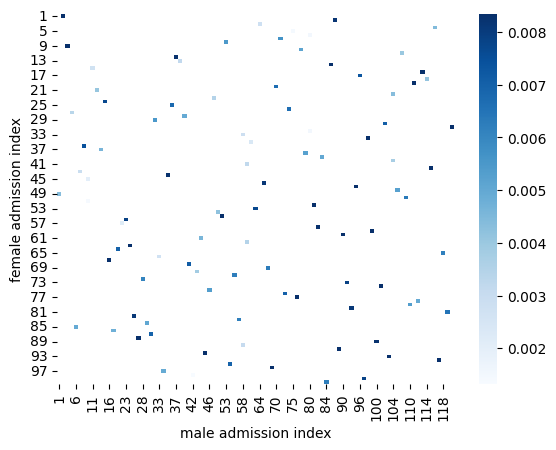

In [38]:
""" 
Match each female with the most likely male by appending the dataframe
"""
selected_df_female = selected_df_female.reset_index(drop=True)
selected_df_male = selected_df_male.reset_index(drop=True)
heatmap_vec = []
for i in range(ot_sinkhorn.coupling_.shape[1]): # for each column
    max_male_index = np.argmax(ot_sinkhorn.coupling_[:, i])
    max_male_prob = np.max(ot_sinkhorn.coupling_[:, i])
    heatmap_vec.append([i+1, max_male_index+1, max_male_prob])
heatmap_df = pd.DataFrame(heatmap_vec, columns=['female_index', 'male_index', 'probability'])

ticksize=10
fig_path = os.path.join(output_dir, "exp4_heatmap.pdf")
ax = sns.heatmap(heatmap_df.pivot('female_index', 'male_index', 'probability'), cmap="Blues")

plt.xlabel("male admission index", fontsize=ticksize)
plt.ylabel("female admission index", fontsize=ticksize)
plt.savefig(fig_path, bbox_inches = 'tight')
plt.show()


In [6]:
""" 
Run multiple iterations using Poisson regression
"""
score_path = os.path.join(output_dir, "exp4_poisson_score_"+str(n_components)+".csv")
male_count = 120
female_count = 100

multi_proc_cts(score_path, n_components, admid_diagnosis_df, custom_train_reps, \
    male_count, female_count, model_func = linear_model.PoissonRegressor, iteration=100)

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 5
iteration: 6


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 7


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 8
iteration: 9
iteration: 10


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 21


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
iteration: 31
iteration: 32
iteration: 33
iteration: 34


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 35
iteration: 36
iteration: 37
iteration: 38
iteration: 39
iteration: 40


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 41
iteration: 42
iteration: 43
iteration: 44
iteration: 45
iteration: 46
iteration: 47
iteration: 48
iteration: 49
iteration: 50


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 51
iteration: 52


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 53
iteration: 54
iteration: 55
iteration: 56
iteration: 57
iteration: 58
iteration: 59
iteration: 60
iteration: 61
iteration: 62
iteration: 63


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 64
iteration: 65
iteration: 66
iteration: 67
iteration: 68
iteration: 69
iteration: 70
iteration: 71
iteration: 72
iteration: 73


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 74
iteration: 75
iteration: 76
iteration: 77


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 78
iteration: 79
iteration: 80
iteration: 81
iteration: 82
iteration: 83
iteration: 84
iteration: 85
iteration: 86
iteration: 87
iteration: 88
iteration: 89
iteration: 90
iteration: 91
iteration: 92
iteration: 93
iteration: 94
iteration: 95
iteration: 96
iteration: 97
iteration: 98
iteration: 99


array([[ 244034.88808661,  322363.2247337 ,  745841.98756727,
        1208683.21081974,  620277.18396048, 1082671.3744462 ],
       [ 286474.71850292,  399262.16438612,  701893.09760331,
        1087206.969321  ,  638860.81291576, 1060226.58216586],
       [ 250622.0544054 ,  350291.64250125,  706246.5796584 ,
        1136433.41383484,  641212.84962535, 1120820.62333433],
       [ 239178.6479832 ,  318011.16405893,  762128.42379069,
        1217830.12821841,  663634.26903162, 1149291.94180012],
       [ 253676.63299406,  345030.63039623,  788864.10734578,
        1238264.07039055,  672707.4834231 , 1130338.27908677],
       [ 265756.21739712,  362960.14218404,  746076.42702754,
        1176181.76657791,  652862.26687841, 1091541.73041475],
       [ 250147.14457041,  337058.61302736,  733217.64647424,
        1164581.33411418,  618630.65701641, 1066791.54819193],
       [ 254568.16781904,  341356.48753415,  726815.90910832,
        1162190.09641602,  615145.5430551 , 1101569.25484474],


In [18]:
# score_path = os.path.join(output_dir, "exp4_poisson_score_"+str(n_components)+".csv")

# save_path = "../../outputs/mimic/exp4_poisson_res.png"
# box_plot_cts_short(score_path, save_path=save_path)


In [8]:
""" 
Run multiple iterations using linear regression
"""
score_path = os.path.join(output_dir, "exp4_linear_score_"+str(n_components)+".csv")
male_count = 120
female_count = 100

multi_proc_cts(score_path, n_components, admid_diagnosis_df, custom_train_reps, \
    male_count, female_count, model_func = linear_model.LinearRegression, iteration=100)

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
iteration: 31


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 32
iteration: 33
iteration: 34
iteration: 35
iteration: 36
iteration: 37
iteration: 38
iteration: 39
iteration: 40
iteration: 41
iteration: 42
iteration: 43
iteration: 44
iteration: 45
iteration: 46
iteration: 47
iteration: 48
iteration: 49
iteration: 50
iteration: 51


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 52
iteration: 53


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 54
iteration: 55
iteration: 56
iteration: 57
iteration: 58
iteration: 59
iteration: 60
iteration: 61
iteration: 62


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 63
iteration: 64


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 65
iteration: 66
iteration: 67
iteration: 68
iteration: 69
iteration: 70


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 71


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 72
iteration: 73
iteration: 74
iteration: 75
iteration: 76
iteration: 77


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 78
iteration: 79
iteration: 80
iteration: 81
iteration: 82
iteration: 83
iteration: 84
iteration: 85
iteration: 86
iteration: 87
iteration: 88
iteration: 89
iteration: 90
iteration: 91
iteration: 92


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 93
iteration: 94
iteration: 95


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 96


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 97
iteration: 98
iteration: 99


array([[ 326986.81693005,  426496.24978262,  927734.01435784,
        1288647.59233696,  702584.21322798, 1178882.52103365],
       [ 309538.89169035,  409964.16057547,  956980.99333949,
        1354768.2430356 ,  726120.03826248, 1199236.31199403],
       [ 326758.43257997,  412957.82463734,  924024.4408119 ,
        1338660.41792245,  714602.48615624, 1205073.61062445],
       [ 327034.36888501,  434719.60515335,  893567.13254687,
        1347212.59828491,  697322.72188767, 1158602.55978918],
       [ 304534.12820013,  408209.04062341,  936503.09017366,
        1344234.64025969,  675519.20558872, 1109359.80000524],
       [ 314883.36358107,  407538.95282513,  922434.79419148,
        1304355.10750035,  673520.22337744, 1111114.05354745],
       [ 294227.52557442,  388547.87762535,  944195.48071901,
        1310117.59857294,  725116.23997643, 1181271.62657682],
       [ 319084.80191586,  417786.73097626,  920427.51902706,
        1313952.91349702,  705342.05846138, 1192591.79727994],


In [20]:
# score_path = os.path.join(output_dir, "exp4_linear_score.csv")
# save_path = "../../outputs/mimic/exp4_linear_res.png"

# box_plot_cts_short(score_path, save_path=save_path)

mae ratio using linear is: 0.7649548494940779
rmse ratio using linear is: 0.8643828397937844
mae ratio using poisson is: 0.8451120341533844
rmse ratio using poisson is: 0.9154057848628719
mae ratio to TCA using linear is: 0.8337621334316695
rmse ratio to TCA using linear is: 0.9037384005721683
mae ratio to TCA using poisson is: 0.755543446360696
rmse ratio to TCA using poisson is: 0.8536507917842849


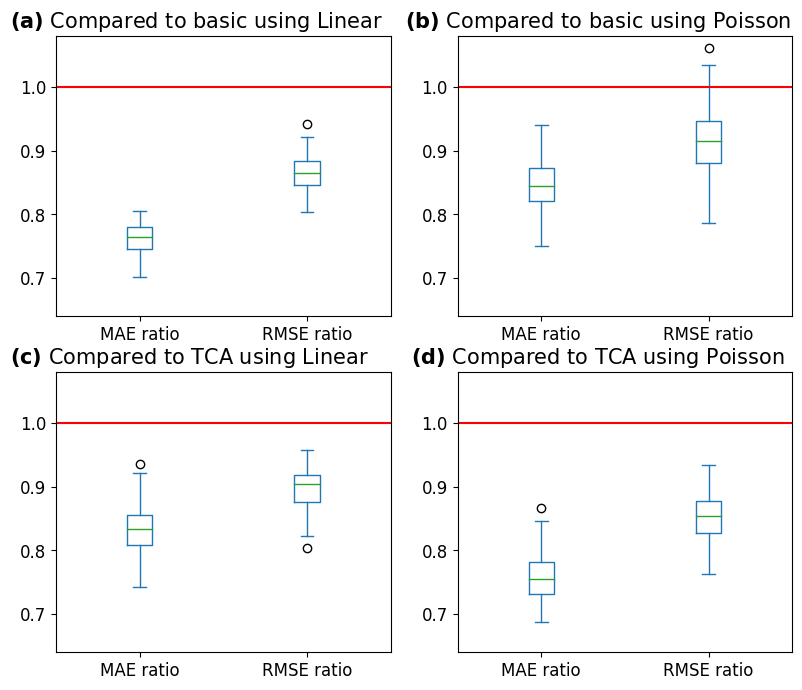

In [41]:
""" 
Combine plots for MIMIC experiment 4 together
"""
n_components = 50
def special_div(x, y):
    """ 
    Special division operation
    """
    if y == 0:
        y = 1e-5
    return x/y

fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(8)
fig.set_figwidth(9.5)
title_size = 15
text_size = 12
linear_score_path = os.path.join(output_dir, "exp4_linear_score_"+str(n_components)+".csv")

linear_scores_df = pd.read_csv(linear_score_path, index_col=None, header=0)

target_mae = linear_scores_df['target_mae']
target_rmse = linear_scores_df['target_rmse']

trans_target_mae = linear_scores_df['trans_target_mae']
trans_target_rmse = linear_scores_df['trans_target_rmse']

# transported source to source mae
trans_target_target_mae = [special_div(i, j) for i, j in zip(trans_target_mae, target_mae)]
print("mae ratio using linear is:", median(trans_target_target_mae))
# transported source to source rmse
trans_target_target_rmse = [special_div(i, j) for i, j in zip(trans_target_rmse, target_rmse)]
print("rmse ratio using linear is:", median(trans_target_target_rmse))


# Pandas dataframe
data = pd.DataFrame({
    'MAE ratio': trans_target_target_mae,
    'RMSE ratio': trans_target_target_rmse
})

# Plot the dataframe
ax = data[['MAE ratio', 'RMSE ratio']].plot(kind='box', ax=axes[0][0])

# Plot the baseline
ax.axhline(y = 1, color = 'r', linestyle = '-')

ax.tick_params(labelsize=text_size)
ax.set_ylim(0.64, 1.08)
ax.set_title(r"$\bf{(a)}$ Compared to basic using Linear", x=0.42, fontsize=title_size)


######################################################

poisson_score_path = os.path.join(output_dir, "exp4_poisson_score_"+str(n_components)+".csv")

poisson_scores_df = pd.read_csv(poisson_score_path, index_col=None, header=0)

target_mae = poisson_scores_df['target_mae']
target_rmse = poisson_scores_df['target_rmse']

trans_target_mae = poisson_scores_df['trans_target_mae']
trans_target_rmse = poisson_scores_df['trans_target_rmse']

# transported source to source mae
trans_target_target_mae = [special_div(i, j) for i, j in zip(trans_target_mae, target_mae)]
print("mae ratio using poisson is:", median(trans_target_target_mae))

# transported source to source rmse
trans_target_target_rmse = [special_div(i, j) for i, j in zip(trans_target_rmse, target_rmse)]
print("rmse ratio using poisson is:", median(trans_target_target_rmse))


# Pandas dataframe
data = pd.DataFrame({
    'MAE ratio': trans_target_target_mae,
    'RMSE ratio': trans_target_target_rmse
})

# Plot the dataframe
ax = data[['MAE ratio', 'RMSE ratio']].plot(kind='box', ax=axes[0][1])

# Plot the baseline
ax.axhline(y = 1, color = 'r', linestyle = '-')

ax.tick_params(labelsize=text_size)
ax.set_ylim(0.64, 1.08)
ax.set_title(r"$\bf{(b)}$ Compared to basic using Poisson", x=0.42, fontsize=title_size)

#####################################################
tca_linear_score_path = os.path.join(output_dir, "exp4_tca_linear_score.csv")

tca_linear_scores_df = pd.read_csv(tca_linear_score_path, index_col=None, header=0)

ot_target_mae = linear_scores_df['trans_target_mae']
ot_target_rmse = linear_scores_df['trans_target_rmse']

tca_target_mae = tca_linear_scores_df['trans_target_mae']
tca_target_rmse = tca_linear_scores_df['trans_target_rmse']

# transported source to source mae
trans_target_target_mae = [special_div(i, j) for i, j in zip(ot_target_mae, tca_target_mae)]
print("mae ratio to TCA using linear is:", median(trans_target_target_mae))

# transported source to source rmse
trans_target_target_rmse = [special_div(i, j) for i, j in zip(ot_target_rmse, tca_target_rmse)]
print("rmse ratio to TCA using linear is:", median(trans_target_target_rmse))

# Pandas dataframe
data = pd.DataFrame({
    'MAE ratio': trans_target_target_mae,
    'RMSE ratio': trans_target_target_rmse
})

# Plot the dataframe
ax = data[['MAE ratio', 'RMSE ratio']].plot(kind='box', ax=axes[1][0])

# Plot the baseline
ax.axhline(y = 1, color = 'r', linestyle = '-')

ax.tick_params(labelsize=text_size)
ax.set_ylim(0.64, 1.08)
ax.set_title(r"$\bf{(c)}$ Compared to TCA using Linear", x=0.40, fontsize=title_size)


####################################################
tca_poisson_score_path = os.path.join(output_dir, "exp4_tca_poisson_score.csv")

tca_poisson_scores_df = pd.read_csv(tca_linear_score_path, index_col=None, header=0)

ot_target_mae = poisson_scores_df['trans_target_mae']
ot_target_rmse = poisson_scores_df['trans_target_rmse']

tca_target_mae = tca_poisson_scores_df['trans_target_mae']
tca_target_rmse = tca_poisson_scores_df['trans_target_rmse']

# transported source to source mae
trans_target_target_mae = [special_div(i, j) for i, j in zip(ot_target_mae, tca_target_mae)]
print("mae ratio to TCA using poisson is:", median(trans_target_target_mae))

# transported source to source rmse
trans_target_target_rmse = [special_div(i, j) for i, j in zip(ot_target_rmse, tca_target_rmse)]
print("rmse ratio to TCA using poisson is:", median(trans_target_target_rmse))

# Pandas dataframe
data = pd.DataFrame({
    'MAE ratio': trans_target_target_mae,
    'RMSE ratio': trans_target_target_rmse
})

# Plot the dataframe
ax = data[['MAE ratio', 'RMSE ratio']].plot(kind='box', ax=axes[1][1])

# Plot the baseline
ax.axhline(y = 1, color = 'r', linestyle = '-')

ax.tick_params(labelsize=text_size)
ax.set_ylim(0.64, 1.08)
ax.set_title(r"$\bf{(d)}$ Compared to TCA using Poisson", x=0.42, fontsize=title_size)
save_path = os.path.join(output_dir, "exp4_res.pdf")
plt.savefig(save_path, bbox_inches='tight')